In [ ]:
%pwd

'/content'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [ ]:
# --- 準備工作：讀取資料與定義變數意義 ---

file_path = 'working_population_health_data.csv'
df = pd.read_csv(file_path)

# 把代碼轉換成有意義的標籤

# 複製一份資料框來做轉換，保留原始數據
df_labeled = df.copy()

# 性別 v45
df_labeled['v45'] = df_labeled['v45'].map({1: '男性', 2: '女性'})

# 遠距工作 v24
df_labeled['v24'] = df_labeled['v24'].map({1: '是', 2: '否'})

# 下班後處理工作 v43
df_labeled['v43'] = df_labeled['v43'].map({1: '是', 2: '否'})

# # 身體狀況變差 v33
# # 簡化為二元變數：1和2代表「有變差」，3,4,5代表「沒有或變好」
# df_labeled['v33_binary'] = df_labeled['v33'].apply(lambda x: '有變差' if x in [1, 2] else '沒有或變好')

# 年齡分組 v4
def age_group(code):
    if code <= 2: return '15-19歲'
    if code <= 3: return '20-29歲'
    if code <= 4: return '30-39歲'
    if code <= 5: return '40-49歲'
    if code <= 6: return '50-59歲'
    return '60-69歲'
df_labeled['age_group'] = df_labeled['v4'].apply(age_group)


In [ ]:
# ==============================================================================
# 步驟一：資料探索與描述性統計
# ==============================================================================
print("================== 步驟一：資料探索與描述性統計 ==================\n")

# 1. 檢視數值型變數的整體統計
print("數值變數統計摘要 (v34是幸福感, v42是AI焦慮, v41是網路工作%):")
print(df[['v34', 'v42', 'v41']].describe())
print("\n" + "="*50 + "\n")

# 2. 檢視類別型變數的分布
print("各類別變數人數分布:")
print("性別分布:\n", df_labeled['v45'].value_counts(), "\n")
print("年齡層分布:\n", df_labeled['age_group'].value_counts(), "\n")
print("下班後是否需處理公事:\n", df_labeled['v43'].value_counts(), "\n")
print("\n" + "="*50 + "\n")


================== 步驟一：資料探索與描述性統計 ==================

數值變數統計摘要 (v34是幸福感, v42是AI焦慮, v41是網路工作%):
               v34          v42          v41
count  6664.000000  6664.000000  6664.000000
mean      7.214586     2.759004    56.748199
std       1.662646     0.892627    39.785643
min       0.000000     1.000000     0.000000
25%       6.000000     2.000000    10.000000
50%       7.000000     3.000000    70.000000
75%       8.000000     3.000000   100.000000
max      10.000000     4.000000   100.000000


各類別變數人數分布:
性別分布:
 v45
男性    3665
女性    2999
Name: count, dtype: int64 

年齡層分布:
 age_group
40-49歲    1904
50-59歲    1714
30-39歲    1377
60-69歲     847
20-29歲     785
15-19歲      37
Name: count, dtype: int64 

下班後是否需處理公事:
 v43
是    3689
否    2975
Name: count, dtype: int64 





In [ ]:
# ==============================================================================
# 步驟二：假設驗證與雙變數分析
# ==============================================================================
print("================== 步驟二：假設驗證與雙變數分析 ==================\n")

# --- 假設1: 下班後處理公事(v43)是否影響主觀幸福感(v34)? ---
group_yes = df[df['v43'] == 1]['v34']
group_no = df[df['v43'] == 2]['v34']

# 執行獨立樣本T檢定
t_stat, p_value = stats.ttest_ind(group_yes, group_no, nan_policy='omit')

print("--- 假設1: 下班後工作 vs 幸福感 ---")
print(f"下班後要處理公事者的平均幸福感: {group_yes.mean():.2f}")
print(f"下班後不需處理公事者的平均幸福感: {group_no.mean():.2f}")
print(f"T檢定 P-value: {p_value:.4f}")
if p_value < 0.05:
    print("結果顯著：下班後是否處理公事，對於主觀幸福感有顯著差異。\n")
else:
    print("結果不顯著：下班後是否處理公事，對於主觀幸福感沒有顯著差異。\n")

# --- 假設2: 對AI的焦慮感(v42)越高，幸福感(v34)是否越低? ---
# 提醒：v42的分數越低代表越焦慮 (1=非常可能被取代)
corr, p_value_corr = stats.pearsonr(df['v42'], df['v34'])

print("--- 假設2: AI取代焦慮感 vs 幸福感 ---")
print(f"AI焦慮感與幸福感的皮爾森相關係數: {corr:.3f}")
print(f"P-value: {p_value_corr:.4f}")
if p_value_corr < 0.05:
    print("結果顯著：AI焦慮感與幸福感之間存在顯著的相關性。")
    if corr > 0:
        print("（解讀：AI焦慮程度越低(分數越高)，幸福感越高。）\n")
    else:
        print("（解讀：AI焦慮程度越高(分數越低)，幸福感越高。）\n")
else:
    print("結果不顯著：AI焦慮感與幸福感之間沒有顯著的相關性。\n")

# --- 假設3: 不同性別(v45)或年齡層在幸福感上是否有差異? ---
male_happiness = df[df['v45'] == 1]['v34']
female_happiness = df[df['v45'] == 2]['v34']
t_stat_gender, p_value_gender = stats.ttest_ind(male_happiness, female_happiness, nan_policy='omit')

print("--- 假設3: 性別 vs 幸福感 ---")
print(f"男性平均幸福感: {male_happiness.mean():.2f}")
print(f"女性平均幸福感: {female_happiness.mean():.2f}")
print(f"P-value: {p_value_gender:.4f}")
if p_value_gender < 0.05:
    print("結果顯著：男女在幸福感上存在顯著差異。\n")
else:
    print("結果不顯著：男女在幸福感上沒有顯著差異。\n")

print("\n" + "="*50 + "\n")

================== 步驟二：假設驗證與雙變數分析 ==================

--- 假設1: 下班後工作 vs 幸福感 ---
下班後要處理公事者的平均幸福感: 7.25
下班後不需處理公事者的平均幸福感: 7.17
T檢定 P-value: 0.0652
結果不顯著：下班後是否處理公事，對於主觀幸福感沒有顯著差異。

--- 假設2: AI取代焦慮感 vs 幸福感 ---
AI焦慮感與幸福感的皮爾森相關係數: 0.062
P-value: 0.0000
結果顯著：AI焦慮感與幸福感之間存在顯著的相關性。
（解讀：AI焦慮程度越低(分數越高)，幸福感越高。）

--- 假設3: 性別 vs 幸福感 ---
男性平均幸福感: 7.16
女性平均幸福感: 7.28
P-value: 0.0040
結果顯著：男女在幸福感上存在顯著差異。





--- 假設4: 身體狀況 vs 幸福感 ---
身體狀況與幸福感的皮爾森相關係數: 0.111
P-value: 0.0000
結果顯著：身體狀況與幸福感之間存在顯著的相關性。
（解讀：身體狀況越好，幸福感越高。）

--- 不同身體狀況等級的幸福感比較 (ANOVA) ---
身體狀況=1 的平均幸福感: 6.93 (n=1400)
身體狀況=2 的平均幸福感: 7.15 (n=2340)
身體狀況=3 的平均幸福感: 7.40 (n=2917)
身體狀況=4 的平均幸福感: 8.25 (n=4)
身體狀況=5 的平均幸福感: 8.00 (n=3)
ANOVA F-statistic: 20.88
P-value: 0.0000


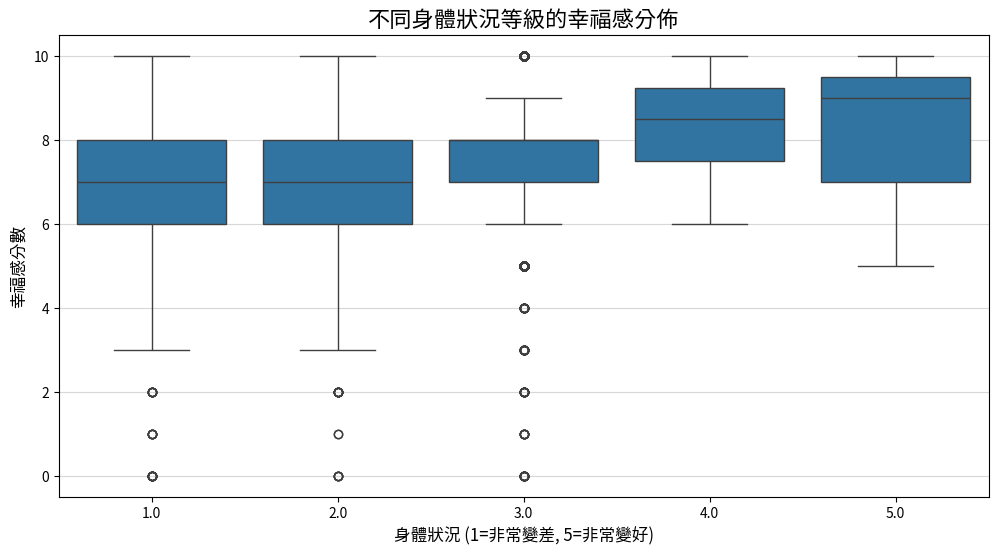

In [ ]:
# --- 假設4: 身體狀況(v33)與主觀幸福感(v34)的關係 ---
# 先進行連續變數的相關性分析
corr_health_happiness, p_value_health = stats.pearsonr(df['v33'], df['v34'])

print("--- 假設4: 身體狀況 vs 幸福感 ---")
print(f"身體狀況與幸福感的皮爾森相關係數: {corr_health_happiness:.3f}")
print(f"P-value: {p_value_health:.4f}")

if p_value_health < 0.05:
    print("結果顯著：身體狀況與幸福感之間存在顯著的相關性。")
    if corr_health_happiness > 0:
        print("（解讀：身體狀況越好，幸福感越高。）\n")
    else:
        print("（解讀：身體狀況越差，幸福感越高。）\n")
else:
    print("結果不顯著：身體狀況與幸福感之間沒有顯著的相關性。\n")

## 使用ANOVA分析不同身體狀況等級的幸福感差異
groups = [df[df['v33'] == i]['v34'] for i in range(1, 6)]
f_stat, p_value_anova = stats.f_oneway(*groups)

print("--- 不同身體狀況等級的幸福感比較 (ANOVA) ---")
for i in range(1, 6):
    group = df[df['v33'] == i]['v34']
    print(f"身體狀況={i} 的平均幸福感: {group.mean():.2f} (n={len(group)})")
print(f"ANOVA F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value_anova:.4f}")

# 視覺化 - 箱形圖展示各等級的幸福感分佈
plt.figure(figsize=(12, 6))
sns.boxplot(x='v33', y='v34', data=df)
plt.title('不同身體狀況等級的幸福感分佈', fontsize=16)
plt.xlabel('身體狀況 (1=非常變差, 5=非常變好)', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:

# ==============================================================================
# 步驟三：建立綜合模型 (多元迴歸分析)
# ==============================================================================
print("==================== 步驟三：建立綜合模型 ====================\n")
print("考慮所有因素，找出影響幸福感(v34)的最關鍵變數。\n")

# 準備迴歸模型的資料
# Y 是依變數 (要預測的目標)
Y = df['v34']
# X 是自變數 (用來預測的因素)
# C(v43)表示將v43視為類別變數
X = df[['v4', 'v45', 'v24', 'v41', 'v43', 'v42', 'v33', 'v8', 'v38']]
X = sm.add_constant(X) # 加入截距項

# 建立並擬合模型
model = sm.OLS(Y, X, missing='drop').fit() # missing='drop'會自動處理缺失值

# 打印出完整的迴歸分析報告
print("--- 多元迴歸分析結果 ---")
print(model.summary())

==================== 步驟三：建立綜合模型 ====================

考慮所有因素，找出影響幸福感(v34)的最關鍵變數。

--- 多元迴歸分析結果 ---
                            OLS Regression Results                            
Dep. Variable:                    v34   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     33.30
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           6.92e-58
Time:                        14:36:53   Log-Likelihood:                -12697.
No. Observations:                6664   AIC:                         2.541e+04
Df Residuals:                    6654   BIC:                         2.548e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [ ]:
print("目標：同時考慮所有因素，找出影響身體(v33)的最關鍵變數。\n")

# 準備迴歸模型的資料
# Y 是依變數 (我們要預測的目標)
Y = df['v33']
# X 是自變數 (我們用來預測的因素)
# C(v43)表示將v43視為類別變數
X = df[['v4', 'v45', 'v24', 'v41', 'v43', 'v42', 'v8', 'v38']]
X = sm.add_constant(X) # 加入截距項

# 建立並擬合模型
model = sm.OLS(Y, X, missing='drop').fit() # missing='drop'會自動處理缺失值

# 打印出完整的迴歸分析報告
print("--- 多元迴歸分析結果 ---")
print(model.summary())

目標：同時考慮所有因素，找出影響身體(v33)的最關鍵變數。

--- 多元迴歸分析結果 ---
                            OLS Regression Results                            
Dep. Variable:                    v33   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     64.59
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          2.03e-102
Time:                        14:36:53   Log-Likelihood:                -7511.6
No. Observations:                6664   AIC:                         1.504e+04
Df Residuals:                    6655   BIC:                         1.510e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

# 解讀迴歸報告
## 1. R-squared: 模型解釋力。此模型可以解釋幸福感變異的百分比
## 2. coef (係數): 每個變數的影響力
- 正數：此變數增加，幸福感傾向增加
- 負數：此變數增加，幸福感傾向降低
## 3. P>|t| (P-value): 顯著性。如果 < 0.05，表示這個變數是影響幸福感的顯著預測因子。")
找出P值小於0.05的那些變數

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-10-20 14:45:44--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.203.139, 172.217.203.101, 172.217.203.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-10-20 14:45:44--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.196.132, 2607:f8b0:400c:c36::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.196.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  37.2MB/s    in 0.5s    

2025-10-20 14

====================== 步驟四：資料視覺化 ======================



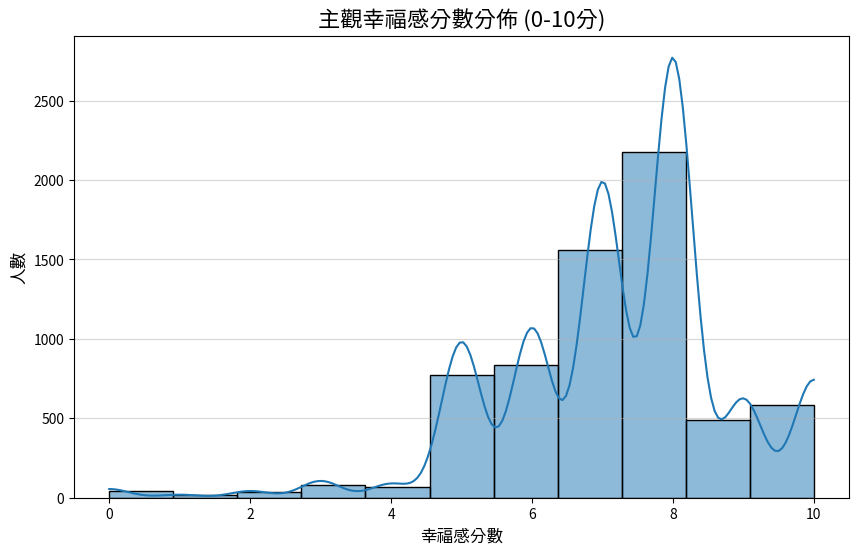

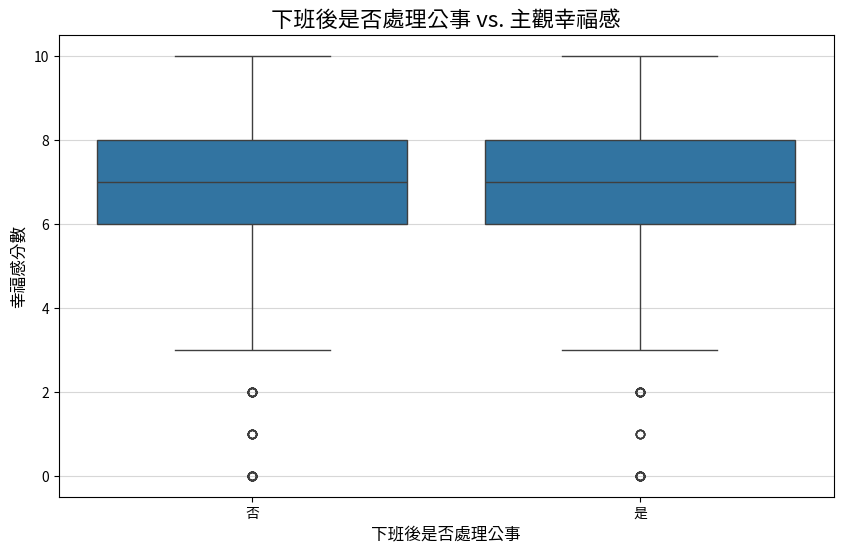

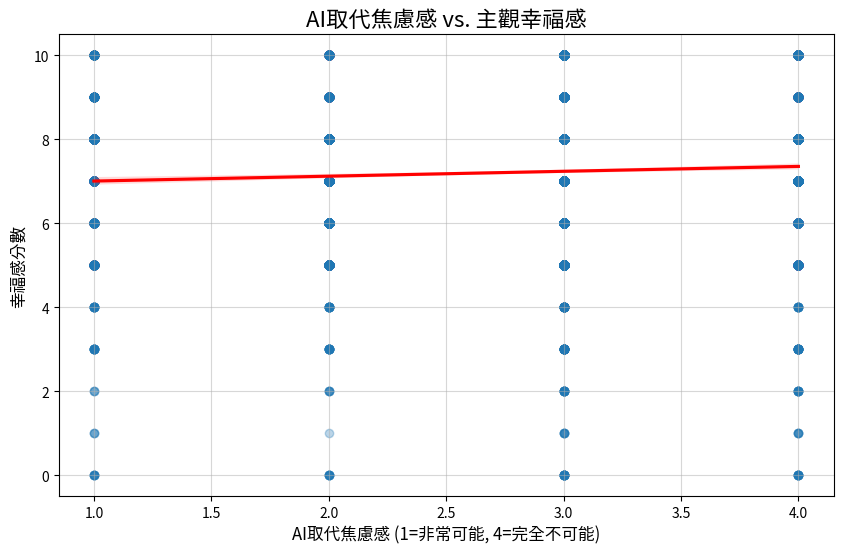

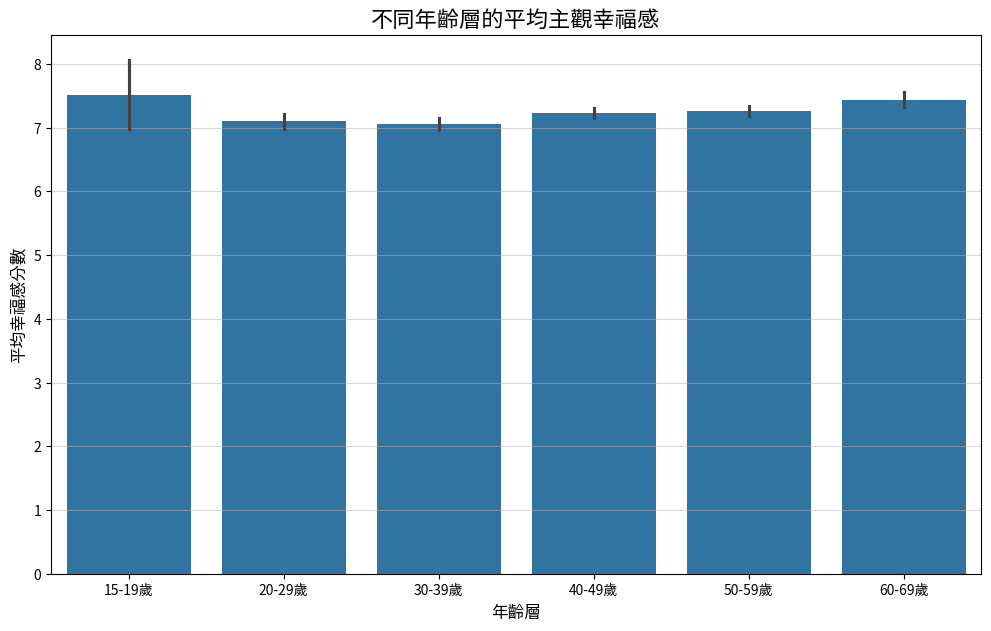

In [ ]:
# ==============================================================================
# 步驟四：資料視覺化
# ==============================================================================
print("====================== 步驟四：資料視覺化 ======================\n")

# 設定中文字體，以避免亂碼
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # for Windows
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# 圖1: 幸福感分數分佈圖 (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['v34'], bins=11, kde=True)
plt.title('主觀幸福感分數分佈 (0-10分)', fontsize=16)
plt.xlabel('幸福感分數', fontsize=12)
plt.ylabel('人數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 圖2: 下班後工作 vs 幸福感 (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='v43', y='v34', data=df_labeled)
plt.title('下班後是否處理公事 vs. 主觀幸福感', fontsize=16)
plt.xlabel('下班後是否處理公事', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 圖3: AI焦慮感 vs 幸福感 (Scatterplot with Regression Line)
plt.figure(figsize=(10, 6))
sns.regplot(x='v42', y='v34', data=df, line_kws={"color": "red"}, scatter_kws={'alpha':0.3})
plt.title('AI取代焦慮感 vs. 主觀幸福感', fontsize=16)
plt.xlabel('AI取代焦慮感 (1=非常可能, 4=完全不可能)', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()

# 圖4: 年齡層 vs 幸福感 (Barplot with error bars)
plt.figure(figsize=(12, 7))
sns.barplot(x='age_group', y='v34', data=df_labeled, order=['15-19歲','20-29歲','30-39歲','40-49歲','50-59歲','60-69歲'])
plt.title('不同年齡層的平均主觀幸福感', fontsize=16)
plt.xlabel('年齡層', fontsize=12)
plt.ylabel('平均幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()